# STIFMap Generation Notebook

The goal of this notebook is to allow users to generate STIFMaps for their own images or sample images available from the manuscript.

## Import necessary packages

In [2]:
# Import functions from the STIFMaps package

from STIFMaps import STIFMap_generation
from STIFMaps.misc import get_step

In [3]:
# Other imports
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scipy import interpolate

import time

## Generate STIFMap for an image of interest

### Specify input files

STIFMaps are generated from paired DAPI and collagen images from the same sample. Additionally, it is necessary to download trained networks to predict collagen stiffness from the `trained_models` folder on [Mendeley](https://data.mendeley.com/datasets/vw2bb5jy99/2). It's recommended to use the first five trained models.

Example images for use in this notebook are available via [GitHub](https://github.com/cstashko/STIFMaps/tree/master/test_cases)

In [5]:
# dapi = '/home/steve/Projects/WeaverLab/STIFMaps/IPMN_images/tiled/27620_C0_full_tile_0_0.tif'
# cna35 = '/home/steve/Projects/WeaverLab/STIFMaps/IPMN_images/tiled/27620_C1_full_tile_0_0.tif'
dapi = '/home/steve/Projects/WeaverLab/STIFMaps/IPMN_images/tiled/27620_C0_full_tile_0_0.tif'
collagen = '/home/steve/Projects/WeaverLab/STIFMaps/IPMN_images/tiled/27620_C1_full_tile_0_0.tif'

In [6]:
# Define the base name and the number of rows and columns
base_name_C0 = "27620_C0_full_tile"
base_name_C1 = "27620_C1_full_tile"
num_rows = 6  # Example: Number of rows in the grid of tiles
num_cols = 7  # Example: Number of columns in the grid of tiles

# Create a list of file names for C0 tiles
C0_files = [f"{base_name_C0}_{i}_{j}.tif" for i in range(num_rows) for j in range(num_cols)]

# Create a list of file names for C1 tiles
C1_files = [f"{base_name_C1}_{i}_{j}.tif" for i in range(num_rows) for j in range(num_cols)]

# Print the list of file names to verify
print("List of C0 names:")
for file_name in C0_files:
    print(file_name)

print("\nList of C1 names:")
for file_name in C1_files:
    print(file_name)

print("Number of C0 files = ", len(C0_files))

List of C0 names:
27620_C0_full_tile_0_0.tif
27620_C0_full_tile_0_1.tif
27620_C0_full_tile_0_2.tif
27620_C0_full_tile_0_3.tif
27620_C0_full_tile_0_4.tif
27620_C0_full_tile_0_5.tif
27620_C0_full_tile_0_6.tif
27620_C0_full_tile_1_0.tif
27620_C0_full_tile_1_1.tif
27620_C0_full_tile_1_2.tif
27620_C0_full_tile_1_3.tif
27620_C0_full_tile_1_4.tif
27620_C0_full_tile_1_5.tif
27620_C0_full_tile_1_6.tif
27620_C0_full_tile_2_0.tif
27620_C0_full_tile_2_1.tif
27620_C0_full_tile_2_2.tif
27620_C0_full_tile_2_3.tif
27620_C0_full_tile_2_4.tif
27620_C0_full_tile_2_5.tif
27620_C0_full_tile_2_6.tif
27620_C0_full_tile_3_0.tif
27620_C0_full_tile_3_1.tif
27620_C0_full_tile_3_2.tif
27620_C0_full_tile_3_3.tif
27620_C0_full_tile_3_4.tif
27620_C0_full_tile_3_5.tif
27620_C0_full_tile_3_6.tif
27620_C0_full_tile_4_0.tif
27620_C0_full_tile_4_1.tif
27620_C0_full_tile_4_2.tif
27620_C0_full_tile_4_3.tif
27620_C0_full_tile_4_4.tif
27620_C0_full_tile_4_5.tif
27620_C0_full_tile_4_6.tif
27620_C0_full_tile_5_0.tif
27620_C0_f

In [13]:
# Specify the DAPI and collagen images to be overlaid
# dapi = '/path/to/test1_DAPI.TIF'
# dapi = '/home/steve/Projects/WeaverLab/STIFMaps/test_cases/with_stain/test1_DAPI.TIF'
# collagen = '/path/to/test1_collagen.TIF'
# collagen = '/home/steve/Projects/WeaverLab/STIFMaps/test_cases/with_stain/test1_collagen.TIF'

# If saving, what should the sample be called?
name = 'IPMN'

# Specify the models to use for stiffness predictions:
# model_dir = '/path/to/trained_models/'
# model_dir = '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/'
# models = [model_dir+model for model in os.listdir(model_dir)]

models = ['/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1171.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1000.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1043.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1161.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1180.pt']
# List the models
models

['/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1171.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1000.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1043.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1161.pt',
 '/home/steve/Projects/WeaverLab/STIFMap_dataset/trained_models/iteration_1180.pt']

### Specify Parameters

These parameters specify the resolution conversion between the input image and the imaging data used to train the models, how many different points to predict stiffness, and how many points to evaluate at once with the model. Note that the choice of `step` is a tradeoff between resolution vs runtime and memory usage while `batch_size` is a tradeoff between memore usage and runtime.

In [7]:
# Networks were trained at a microscopy resolution of 4.160 pixels/micron (0.2404 microns/pixel)
# Provide a scale factor to resize the input images to this resolution
# Ex: Images at 2.308 pixels/micron require a scale_factor of 1.802
# scale_factor = 1.802
scale_factor = 2.712

# Stifness is predicted for each square. This is the distance from the center of one square to the next
step = 40

# How many squares to evaluate at once with the network
batch_size = 100

### Given the scale_factor, what are the actual square dimensions and step sizes that will be used?

In [8]:
# Given the scale_factor, what is the actual step size (in pixels) from one square to the next?
step = get_step(step, scale_factor)

print('Step size is ' + str(step) + ' pixels')

# Get the actual side length of one square
# The models expect input squares that are 224 x 224 pixels. 
# Given the scale_factor, how many pixels is that in these images?
square_side = get_step(224, scale_factor)

print('Side length for a square is ' + str(square_side) + ' pixels')

Step size is 14 pixels
Side length for a square is 82 pixels


### Get STIFMap

STIFMaps are computed using the function `generate_STIFMap`, which has the following inputs:
 - **dapi**: The path to the DAPI image to use
 - **collagen**: The path to the collagen image to use
 - **name**: The prefix to use for saving the predictions, if 'save_dir' is specified
 - **step**: The step size to use between squares
 - **models**: The list of trained networks to use for predictions
 - **mask**: (Optional) The path to a 2D mask the same dimension as 'dapi' of zeros and ones that specifies regions to exclude when predicting stiffness 
 - **batch_size**: How many squares should be evaluated by one model at once
 - **square_side**: The side length of each square to evaluate in the model
 - **save_dir**: Where to save the stiffness predictions, or 'False' if saving is not desired
 
Output: `generate_STIFMap` returns a 3D numpy array of the stiffness predictions for the 'dapi'/'collagen' images for each of the included models

Device is cpu


/home/steve/.local/lib/python3.10/site-packages/STIFMaps/STIFMap_generation.py:145: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(np.moveaxis(im, 0, -1))


Image shape is (3, 5003, 5003)
Num squares in x direction is 352
Num squares in y direction is 352
Time taken to predict squares is 490.96458649635315
Time taken to predict squares is 980.7691640853882
Time taken to predict squares is 1473.8906066417694
Time taken to predict squares is 1963.9621739387512
Time taken to predict squares is 2461.081844806671
Total time taken is 2462.081447839737
Saved image: /home/steve/Projects/WeaverLab/STIFMaps/z_out/stiffness_map.png
CPU times: user 5h 2min 21s, sys: 18min 8s, total: 5h 20min 29s
Wall time: 41min 2s


<timed exec>:19: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
/home/steve/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


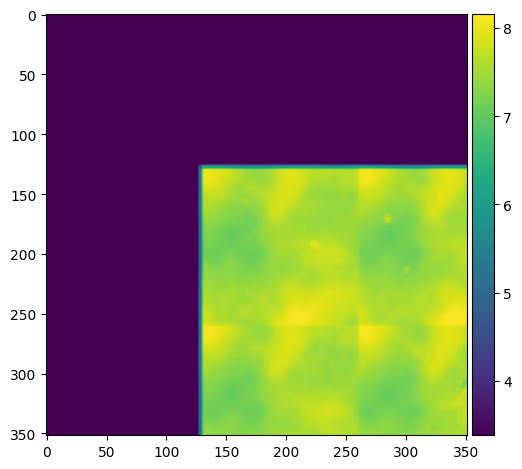

In [7]:
%%time

def run_STIFMap (dapi, collagen, name, step, models, batch_size, square_side):
    
    # Generate the stiffness predictions
    z_out = STIFMap_generation.generate_STIFMap(dapi, collagen, name, step, models=models,
                    mask=False, batch_size=batch_size, square_side=square_side,
                    save_dir=False)
    
    # Average the channels to get a 2D array
    output_image = np.mean(z_out, axis=0)
    
    # Normalize the image to the range [0, 1]
    output_image_normalized = output_image / output_image.max()
    
    # Save the image using matplotlib
    output_path = '/home/steve/Projects/WeaverLab/STIFMaps/z_out/stiffness_map.png'
    plt.imsave(output_path, output_image_normalized, cmap="viridis")
    print(f"Saved image: {output_path}")
    
    # Show the output image
    # `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Using `matplotlib` in the next cell to visualize images.
    io.imshow(np.mean(z_out, axis=0))

dapi path=/home/steve/Projects/WeaverLab/STIFMaps/IPMN_images/normalized_tiled/27620_C0_full_tile_0_4.tif
collagen path=/home/steve/Projects/WeaverLab/STIFMaps/IPMN_images/normalized_tiled/27620_C1_full_tile_0_4.tif
Device is cpu


/home/steve/.local/lib/python3.10/site-packages/STIFMaps/STIFMap_generation.py:145: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(np.moveaxis(im, 0, -1))


Image shape is (3, 5003, 5003)
Num squares in x direction is 352
Num squares in y direction is 352
Time taken to predict squares is 495.10348320007324
Time taken to predict squares is 988.5122442245483
Time taken to predict squares is 1495.4415192604065
Time taken to predict squares is 2043.7005133628845
Time taken to predict squares is 2592.5295157432556
Total time taken is 2593.6089985370636
CPU times: user 5h 16min 2s, sys: 18min 6s, total: 5h 34min 9s
Wall time: 43min 13s


<timed exec>:20: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
/home/steve/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


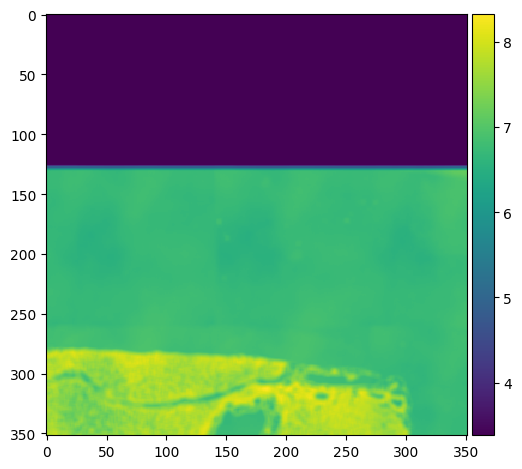

In [25]:
%%time

project_dir = '/home/steve/Projects/WeaverLab/STIFMaps'
IPMN_directory = os.path.join(project_dir, "IPMN_images")
STIFMaps_directory = os.path.join(project_dir, "STIFMap_images_new")
name = 'test'

i = 0
j = 4
dapi = os.path.join(IPMN_directory, 'normalized_tiled', C0_files[i * num_cols + j])
collagen = os.path.join(IPMN_directory, 'normalized_tiled', C1_files[i * num_cols + j])

print(f'dapi path={dapi}')
print(f'collagen path={collagen}')
scale_factor = 2.712
# Generate the stiffness predictions
z_out = STIFMap_generation.generate_STIFMap(dapi, collagen, name, step, models=models,
                    mask=False, batch_size=batch_size, square_side=square_side,
                    save_dir=False)
# Show the output image
# `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Using `matplotlib` in the next cell to visualize images.
io.imshow(np.mean(z_out, axis=0))

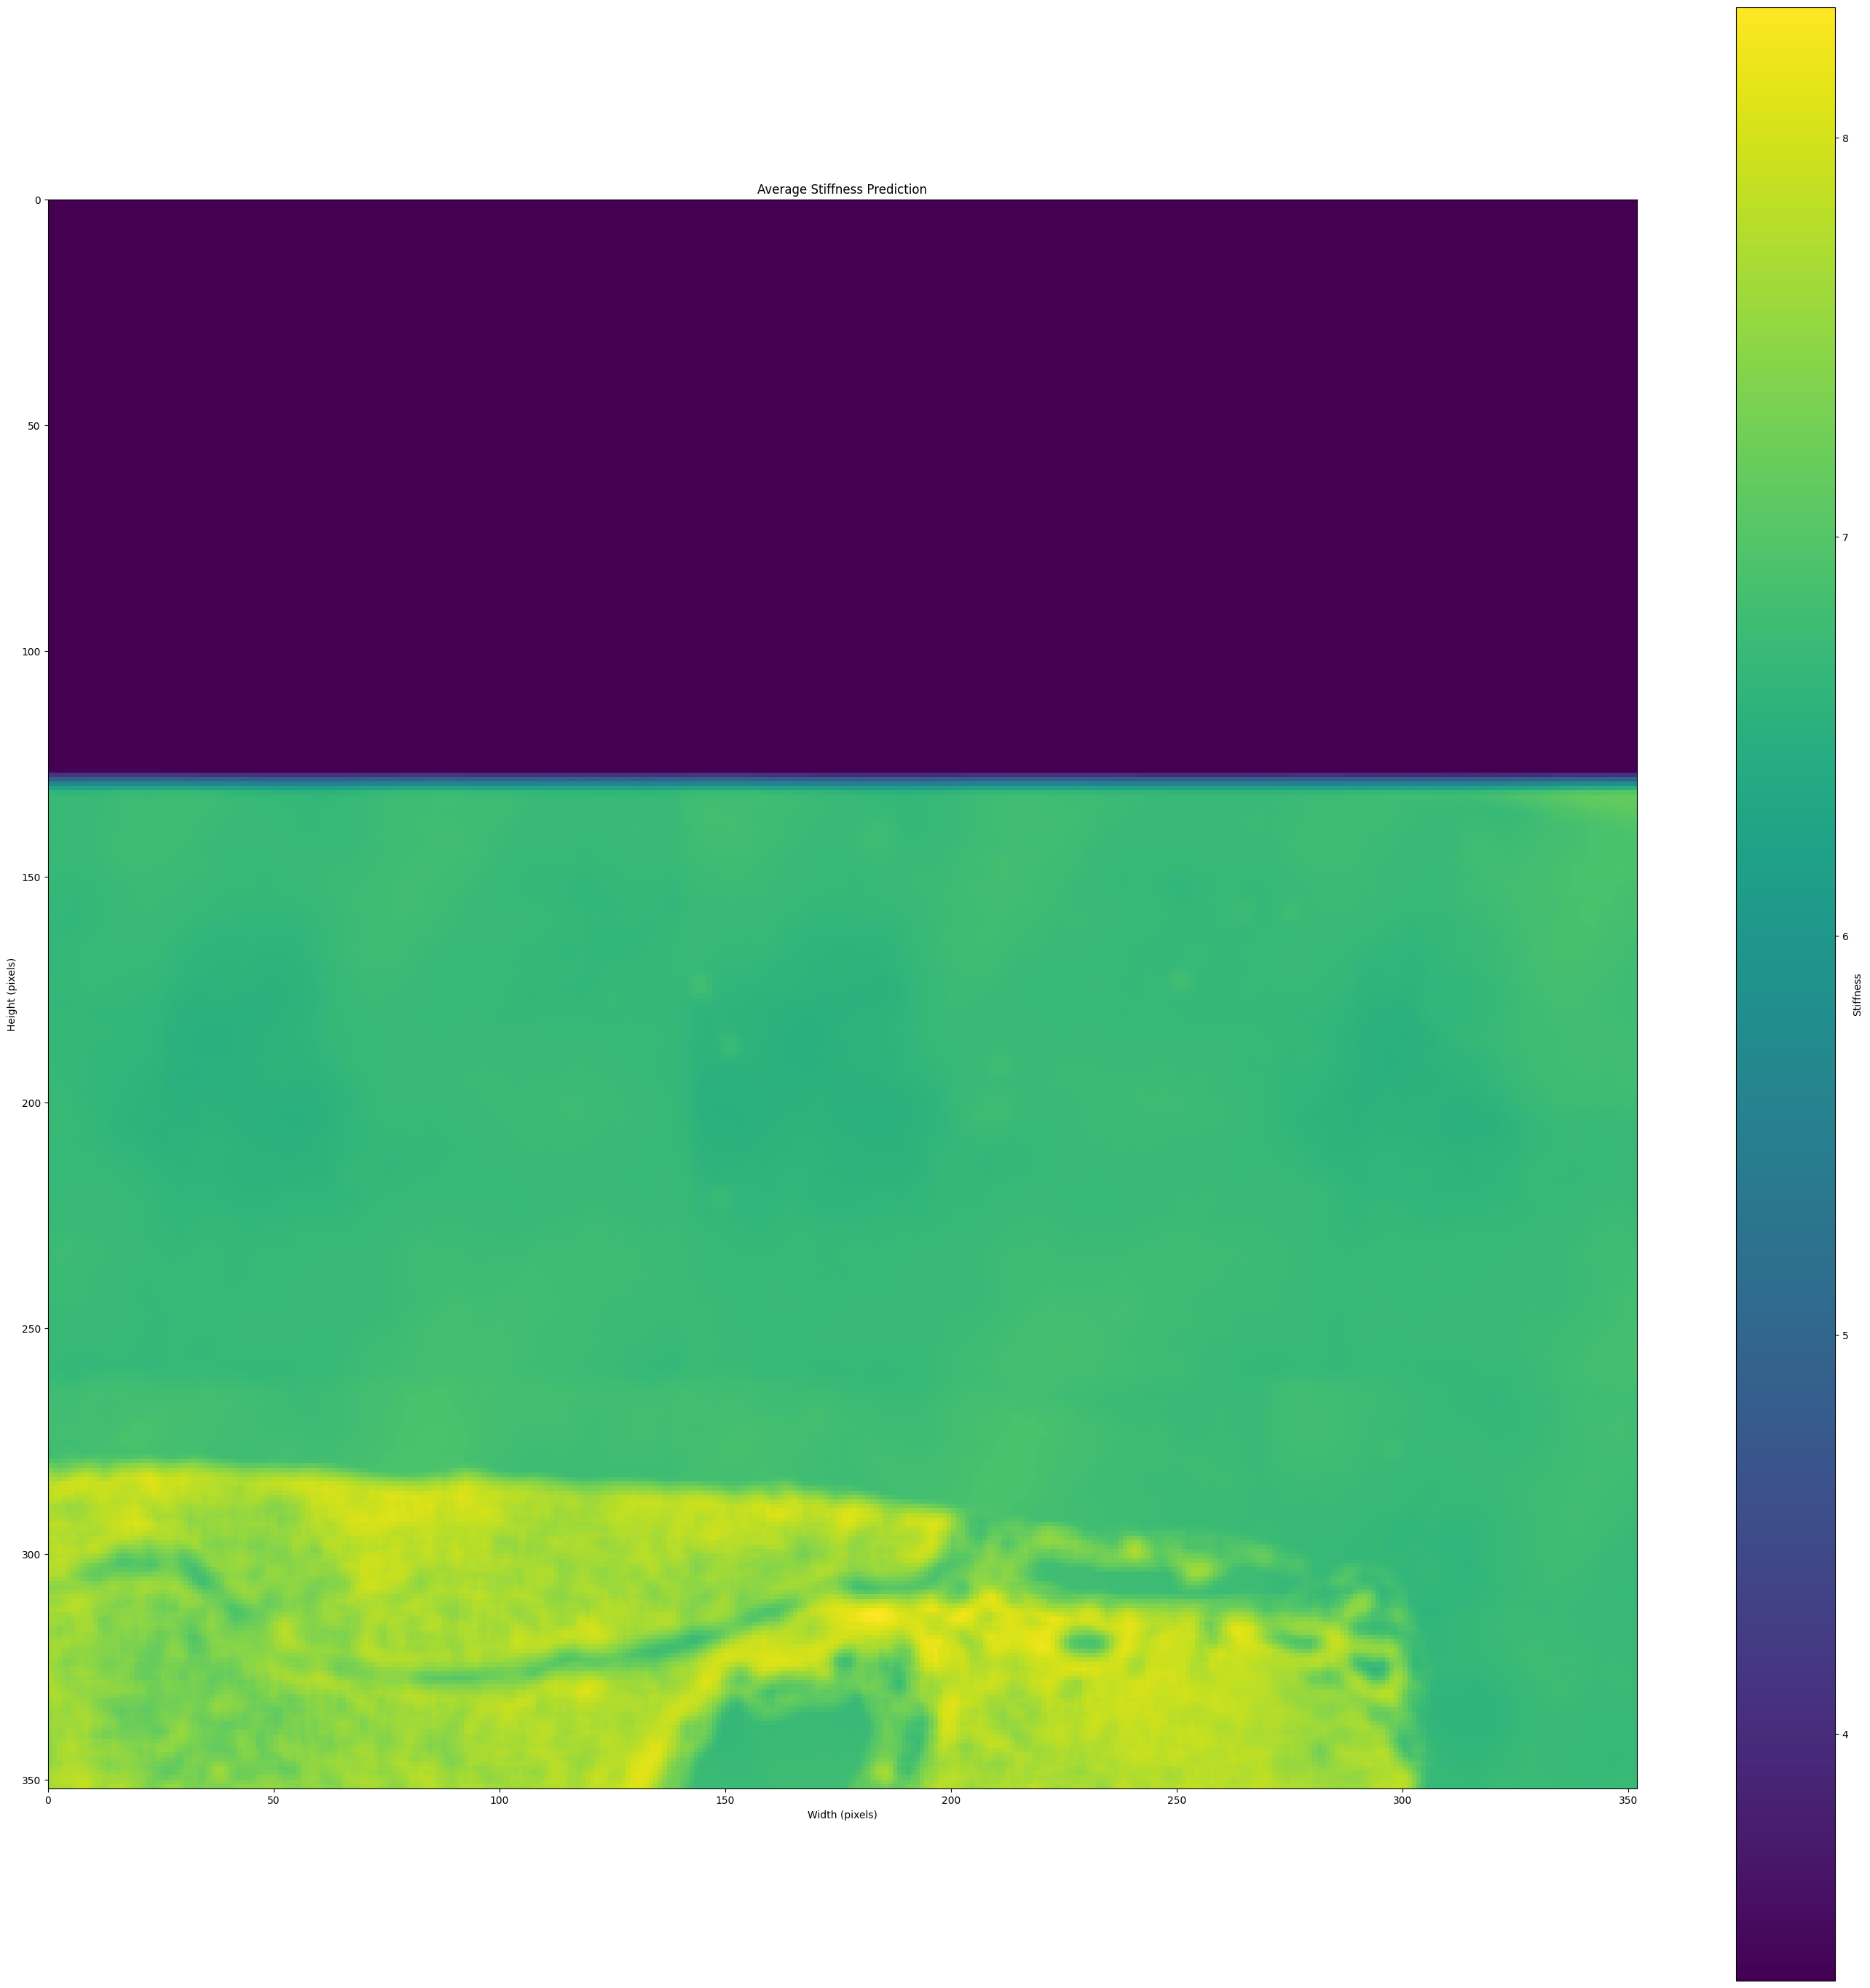

<Figure size 640x480 with 0 Axes>

In [26]:
# Get the dimensions of the image
height, width = np.mean(z_out, axis=0).shape

# Visualize the output using matplotlib with the same size
plt.figure(figsize=(width / 10, height / 10))  # Adjust th|e figure size
plt.imshow(np.mean(z_out, axis=0), cmap='viridis', extent=[0, width, height, 0])
plt.colorbar(label='Stiffness')
plt.title('Average Stiffness Prediction')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.show()
plt.savefig('./out.png', format='png')

<Figure size 640x480 with 0 Axes>

## Collagen Painting

The collagen image may be pseudocolored to indicate the predicted stiffness of the collagen fibers. This is done using the function `collagen_paint`, which has the following inputs:

 - **dapi**: The path to the DAPI image to use
 - **collagen**: The path to the collagen image to use
 - **z**: The stiffness prediction values computed above
 - **name**: The prefix to use for saving the predictions, if 'save_dir' is specified
 - **step**: The step size used between squares
 - **mask**: (Optional) The path to a 2D mask the same dimension as 'dapi' of zeros and ones that specifies regions to exclude when coloring collagen 
 - **square_side**: The side length of each square evaluated in the model
 - **scale_percent**: An integer from 1-100 specifying how much to scale down the images if memory usage or runtime is too high. Note that a value of 100 means that the images will not be scaled down at all
 - **save_dir**: Where to save the collagen-painted image, or 'False' if saving is not desired
 
Output: In addition to saving the collagen-painted image (if specified), `collagen_paint` returns an RGB image of the pseudocolored collagen

test
Time taken is 3.3157293796539307


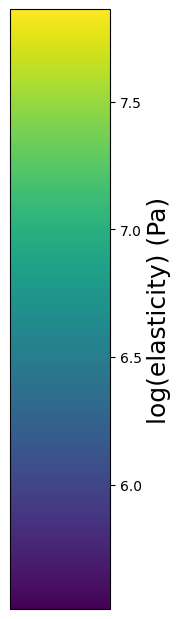

In [22]:
# col_colored = STIFMap_generation.collagen_paint(dapi, collagen, z_out, name, step,
#                     mask=False, square_side=square_side,
#                     scale_percent=100, save_dir=False)

col_colored = STIFMap_generation.collagen_paint(dapi, collagen, z_out, name, step,
                    mask=False, square_side=square_side,
                    scale_percent=100, save_dir=False)

/tmp/ipykernel_9125/1685881304.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(col_colored)


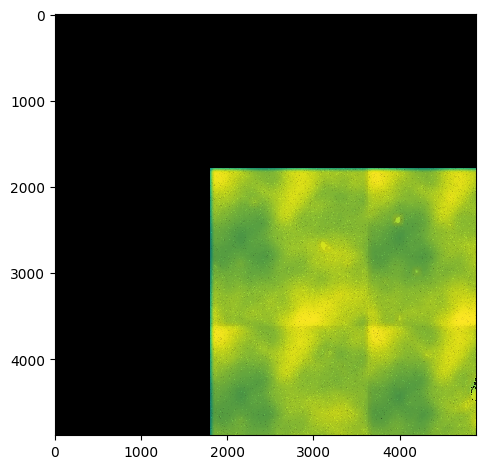

In [15]:
# Show the pseudocolored collagen image
io.imshow(col_colored)

# Correlate predicted stiffness with a staining marker of interest

Given an additional staining image taken at the same region as the DAPI and collagen images, we can compute the correlation between the staining intensity and the intensity of collagen, DAPI, and predicted stiffness using the function `correlate_signals_with_stain`, which has the following inputs:

 - **dapi**: The path to the DAPI image to use
 - **collagen**: The path to the collagen image to use
 - **z**: The stiffness prediction values computed above
 - **stain**: The path to the staining image to use
 - **step**: The step size used between squares
 - **mask**: (Optional) The path to a 2D mask the same dimension as 'dapi' of zeros and ones that specifies regions to exclude when coloring collagen 
 - **square_side**: The side length of each square evaluated in the model
 - **scale_percent**: An integer from 1-100 specifying how much to scale down the images if memory usage or runtime is too high. Note that a value of 100 means that the images will not be scaled down at all
 - **quantile**: A float between zero and one specifying the quantile of stain intensity of use for each percentile of DAPI/collagen/STIFMap intensity. See the manuscript for more details
 
Output: `correlate_signals_with_stain` returns the Spearman correlation values between the staining intensity and the intensity of DAPI, collagen, and stiffness predictions

In [16]:
# Specify the staining file to use
# stain = '/path/to/test1_stain.TIF'
stain = '/home/steve/Projects/WeaverLab/STIFMaps/test_cases/with_stain/test1_stain.TIF'

# The pixel threshold to use when comparing STIFMaps/DAPI/collagen vs stain intensity
quantile = .99

In [18]:
# Correlate the stain intensity with the intensity of collagen, DAPI, and predicted stiffness
# z_stain_corr, collagen_stain_corr, dapi_stain_corr = STIFMap_generation.correlate_signals_with_stain(
#     dapi, collagen, z_out, stain, step,
#     mask=False, square_side=square_side, 
#     scale_percent=100, quantile=quantile)

z_stain_corr, cna35_stain_corr, dapi_stain_corr = STIFMap_generation.correlate_signals_with_stain(
    dapi, cna35, z_out, stain, step,
    mask=False, square_side=square_side, 
    scale_percent=100, quantile=quantile)

Spearman correlation between stain and predicted stiffness is 0.3060600374908994
Spearman correlation between stain and collagen is 0.8244980292302615
Spearman correlation between stain and dapi is 0.5196380285169672
time taken is 545.6827619075775
